In [2]:
library('protr')
library('idpr')
library('patchwork')
library('ggplot2')
library('repr')
library('msa')
library('seqinr')
library('ape')
library('corrplot')

### The idea of the project is the following:

Firstly, we consider only human MEF2 genes and try to see if there is a "visual" difference between MEF2A/MEF2D (proteins involved into synaptic regulation) and MEF2B/MEF2C. We can derive initial ideas of descriptors that can help to find the difference between these two groups on a primary-structure level.

Secondly, we take all the available reviewed MEF2 genes from UNIPROT, derive the chosen descriptors, then later perform a T-test in order to see if the difference between two groups of proteins is statistically significant.


# 1. Manual analysis of human MEF2 genes

First of all we load FASTA sequences of MEF2A, MEF2B, MEF2C, MEF2D, taken from UNIPROT.

In [3]:
mef2a <- readFASTA('MEF2A_human.fasta')[[1]]
mef2b <- readFASTA('MEF2B_human.fasta')[[1]]
mef2c <- readFASTA('MEF2C_human.fasta')[[1]]
mef2d <- readFASTA('MEF2D_human.fasta')[[1]]

### 1a) Length of the sequence
The first thing to see is the length of the protein sequence:

In [4]:
cat('MEF2A length: ', nchar(mef2a), '\n')
cat('MEF2B length: ', nchar(mef2b), '\n')
cat('MEF2C length: ', nchar(mef2c), '\n')
cat('MEF2D length: ', nchar(mef2d), '\n')

MEF2A length:  507 
MEF2B length:  365 
MEF2C length:  473 
MEF2D length:  521 


As it can be seen, two proteins involved in the regulation of synaptic activity are longer.

### 1b) Amino acid composition 

This descriptor is defined as:

$ f(a) = \cfrac{N_a}{N}$, $a = 1, 2 ... 20$

$N_a$ is the number of amino acids of type $a$ and $N$ is the length of the protein's sequence.

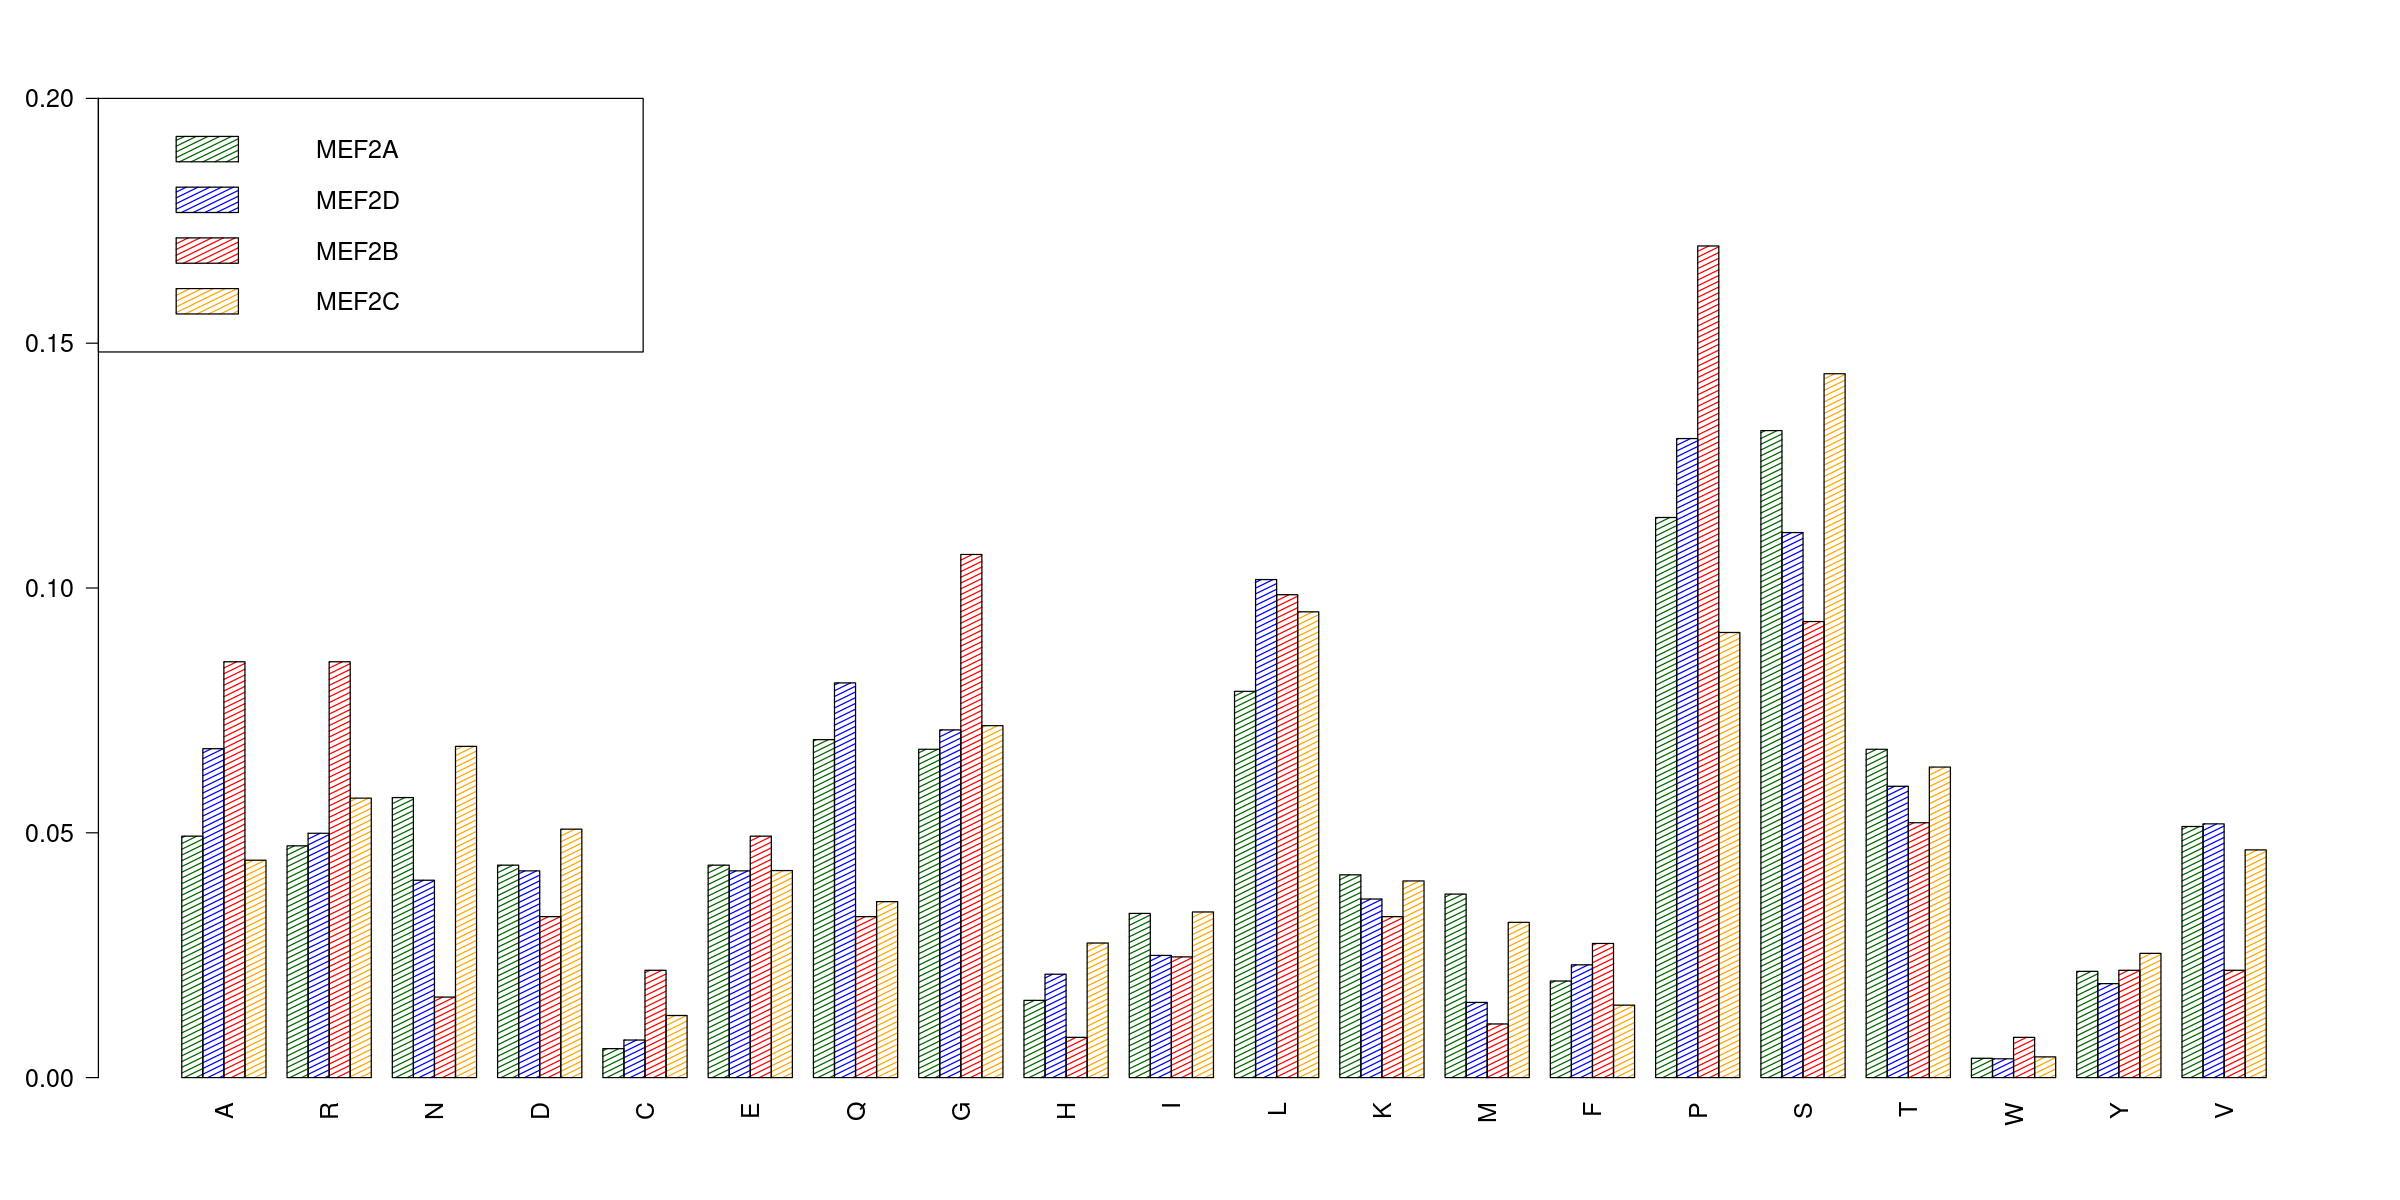

In [5]:
options(repr.plot.width=20, repr.plot.height=10)

grouped_AA <- rbind(extractAAC(mef2a), extractAAC(mef2d), extractAAC(mef2b), extractAAC(mef2c))
barplot(grouped_AA, beside = TRUE,
        names.arg = names(extractAAC(mef2a)), las = 2,
        col = c("darkgreen", "blue", "red", "orange"),
        density = 50,
        ylim = c(0,0.2),
        legend.text = c('MEF2A', 'MEF2D', 'MEF2B', 'MEF2C'),
        args.legend = list(cex=1.25,x = "topleft"),
        cex.lab = 1.5,
        cex.axis = 1.25,
        cex = 1.25)

This plot does not tell us a lot, but we can see that for glutamine (Q) the diffrence is quiet clear: its frequency for MEF2A/MEF2D is bigger. For other amino acids we either cannot tell anything significant for two groups or the differences in frequencies does not appear to be meaningful by visual analysis.

### 1c) Amino acid composition by groups

We can proceed and see if there are more insights, if we group amino acids by their type (positively charged, negatively charged, non-polar or polar).

Here we just find the total frequencis of amino acids by different types and organise everything into dataframe.

In [6]:
polar <- c('S', 'T', 'Y', 'N', 'Q')
non_polar <- c('G', 'A', 'V', 'C', 'P', 'L', 'I', 'M', 'W', 'F')
charge_pl <- c('K', 'R', 'H')
charge_m <- c('D', 'E')

Name <- c('MEF2A', 'MEF2D', 'MEF2B', 'MEF2C')
Polar <- rowSums(grouped_AA[, polar])
Non_polar <- rowSums(grouped_AA[, non_polar])
Charge_plus <- rowSums(grouped_AA[, charge_pl])
Charge_minus <- rowSums(grouped_AA[, charge_m])

df <- data.frame(Name, Polar, Non_polar, Charge_plus, Charge_minus)
df

Name,Polar,Non_polar,Charge_plus,Charge_minus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MEF2A,0.3471400,0.4615385,0.1045365,0.08678501
MEF2D,0.3109405,0.4971209,0.1074856,0.08445298
MEF2B,0.2164384,0.5753425,0.1260274,0.08219178
MEF2C,0.3361522,0.4460888,0.1247357,0.09302326


To facilitate seeing the patterns, MEF2A can be taken as a reference.

In [7]:
diff_pr <- function(df, pr1, pr2){
    
    df[Name==pr2, ]$Polar <- df[Name==pr1, ]$Polar - df[Name==pr2, ]$Polar
    df[Name==pr2, ]$Non_polar <- df[Name==pr1, ]$Non_polar - df[Name==pr2, ]$Non_polar
    df[Name==pr2, ]$Charge_plus <- df[Name==pr1, ]$Charge_plus - df[Name==pr2, ]$Charge_plus
    df[Name==pr2, ]$Charge_minus <- df[Name==pr1, ]$Charge_minus - df[Name==pr2, ]$Charge_minus
    
    return(df)
}


df2 <- diff_pr(df, 'MEF2A', 'MEF2D')
df2 <- diff_pr(df2, 'MEF2A', 'MEF2B')
df2 <- diff_pr(df2, 'MEF2A', 'MEF2C')
df2

Name,Polar,Non_polar,Charge_plus,Charge_minus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MEF2A,0.34714004,0.46153846,0.104536489,0.086785010
MEF2D,0.03619954,-0.03558246,-0.002949115,0.002332035
MEF2B,0.13070168,-0.11380400,-0.021490908,0.004593229
MEF2C,0.01098782,0.01544967,-0.020199240,-0.006238246


It can be seen that:

- for polar amino acids the "farthest" protein is MEF2B, the "nearest" - MEF2C
- for non-polar: "farthest" - MEF2B, "nearest" - MEF2C
- for charge+: "farthest" - MEF2B (although MEF2C has a similar value), "nearest" - MEF2D
- for charge-: "farthest" - MEF2C, "nearest" - MEF2D

To sum up, based on these four amino acids groups, MEF2A and MEF2D are the nearest in terms of charged amino acids (both positive and negative), but there is no such proximity in terms of having polar/non-polar amino acids.


### 1d) Local hydrophobicity profile and global charge distribution


Now we can analyse the MEF2 hydrophobicity profile and charge distribution.

For local hydropathy calculation the Kyte-Doolittle scale is used.

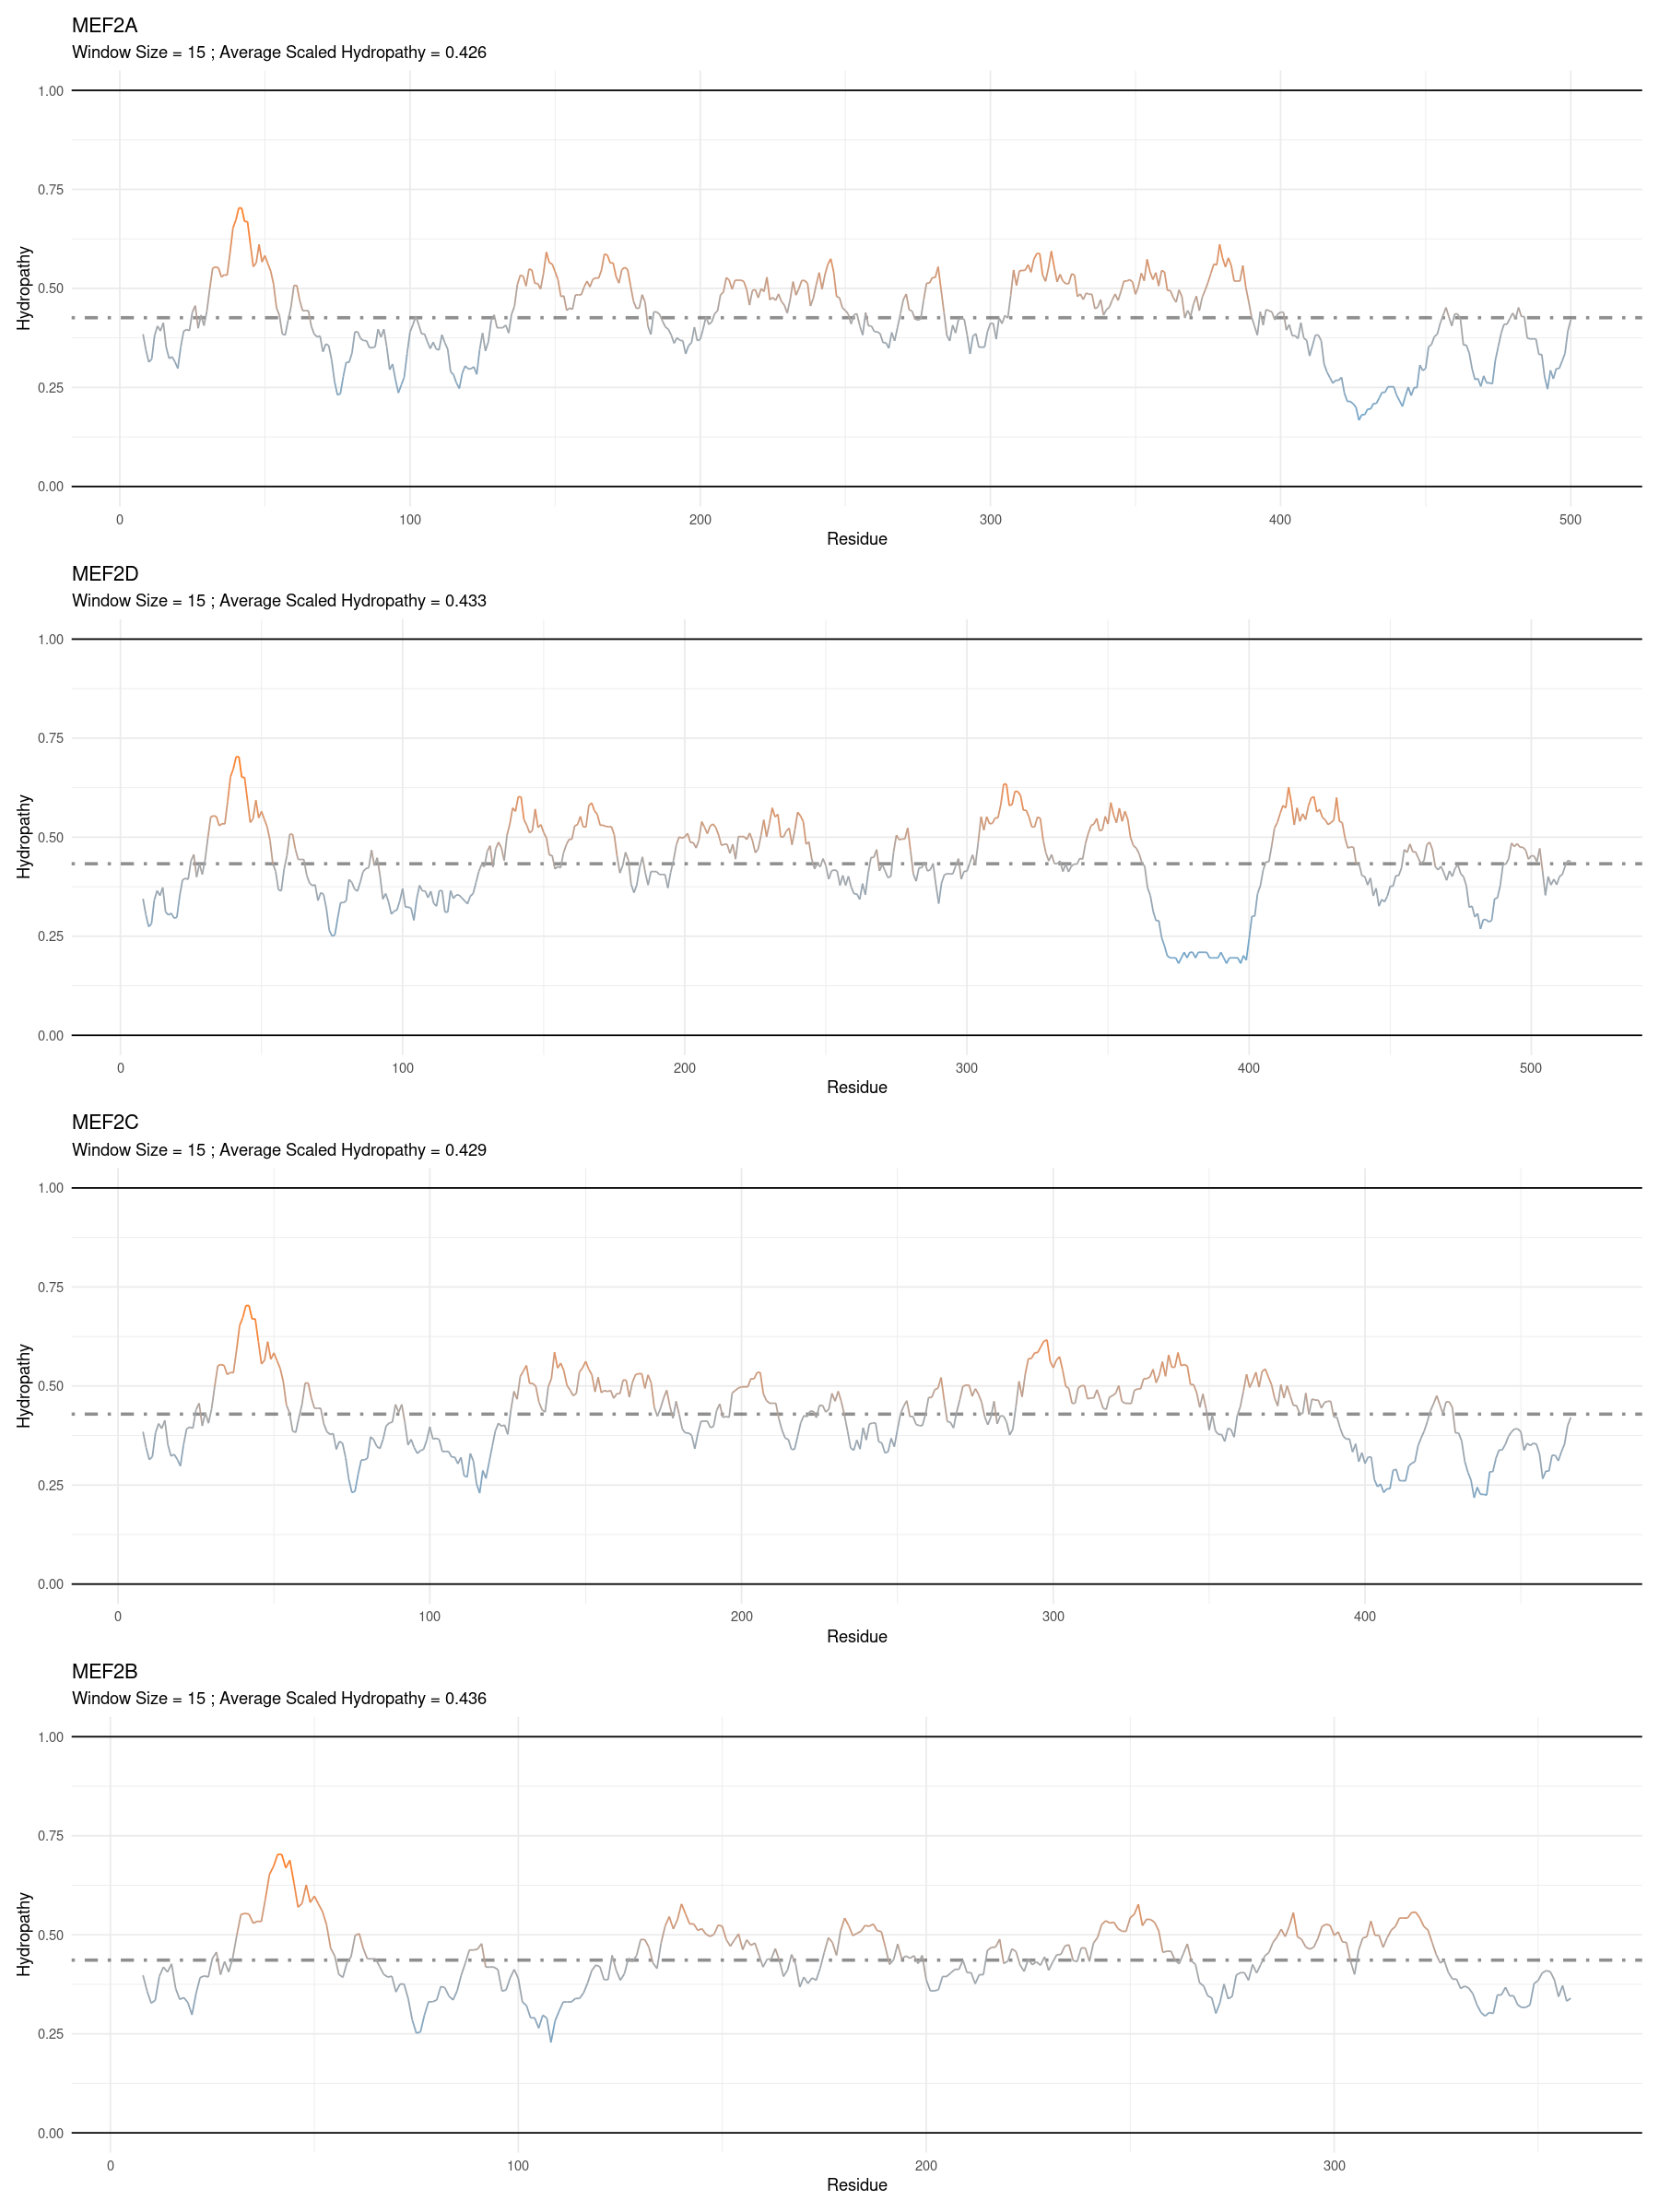

In [8]:
options(repr.plot.width=15, repr.plot.height=20)

hylocal_a <- scaledHydropathyLocal(mef2a, plotResults = TRUE, window = 15) + ggtitle('MEF2A')
hylocal_b <- scaledHydropathyLocal(mef2b, plotResults = TRUE, window = 15) + ggtitle('MEF2B')
hylocal_c <- scaledHydropathyLocal(mef2c, plotResults = TRUE, window = 15) + ggtitle('MEF2C')
hylocal_d <- scaledHydropathyLocal(mef2d, plotResults = TRUE, window = 15) + ggtitle('MEF2D')

hylocal_a / hylocal_d / hylocal_c / hylocal_b

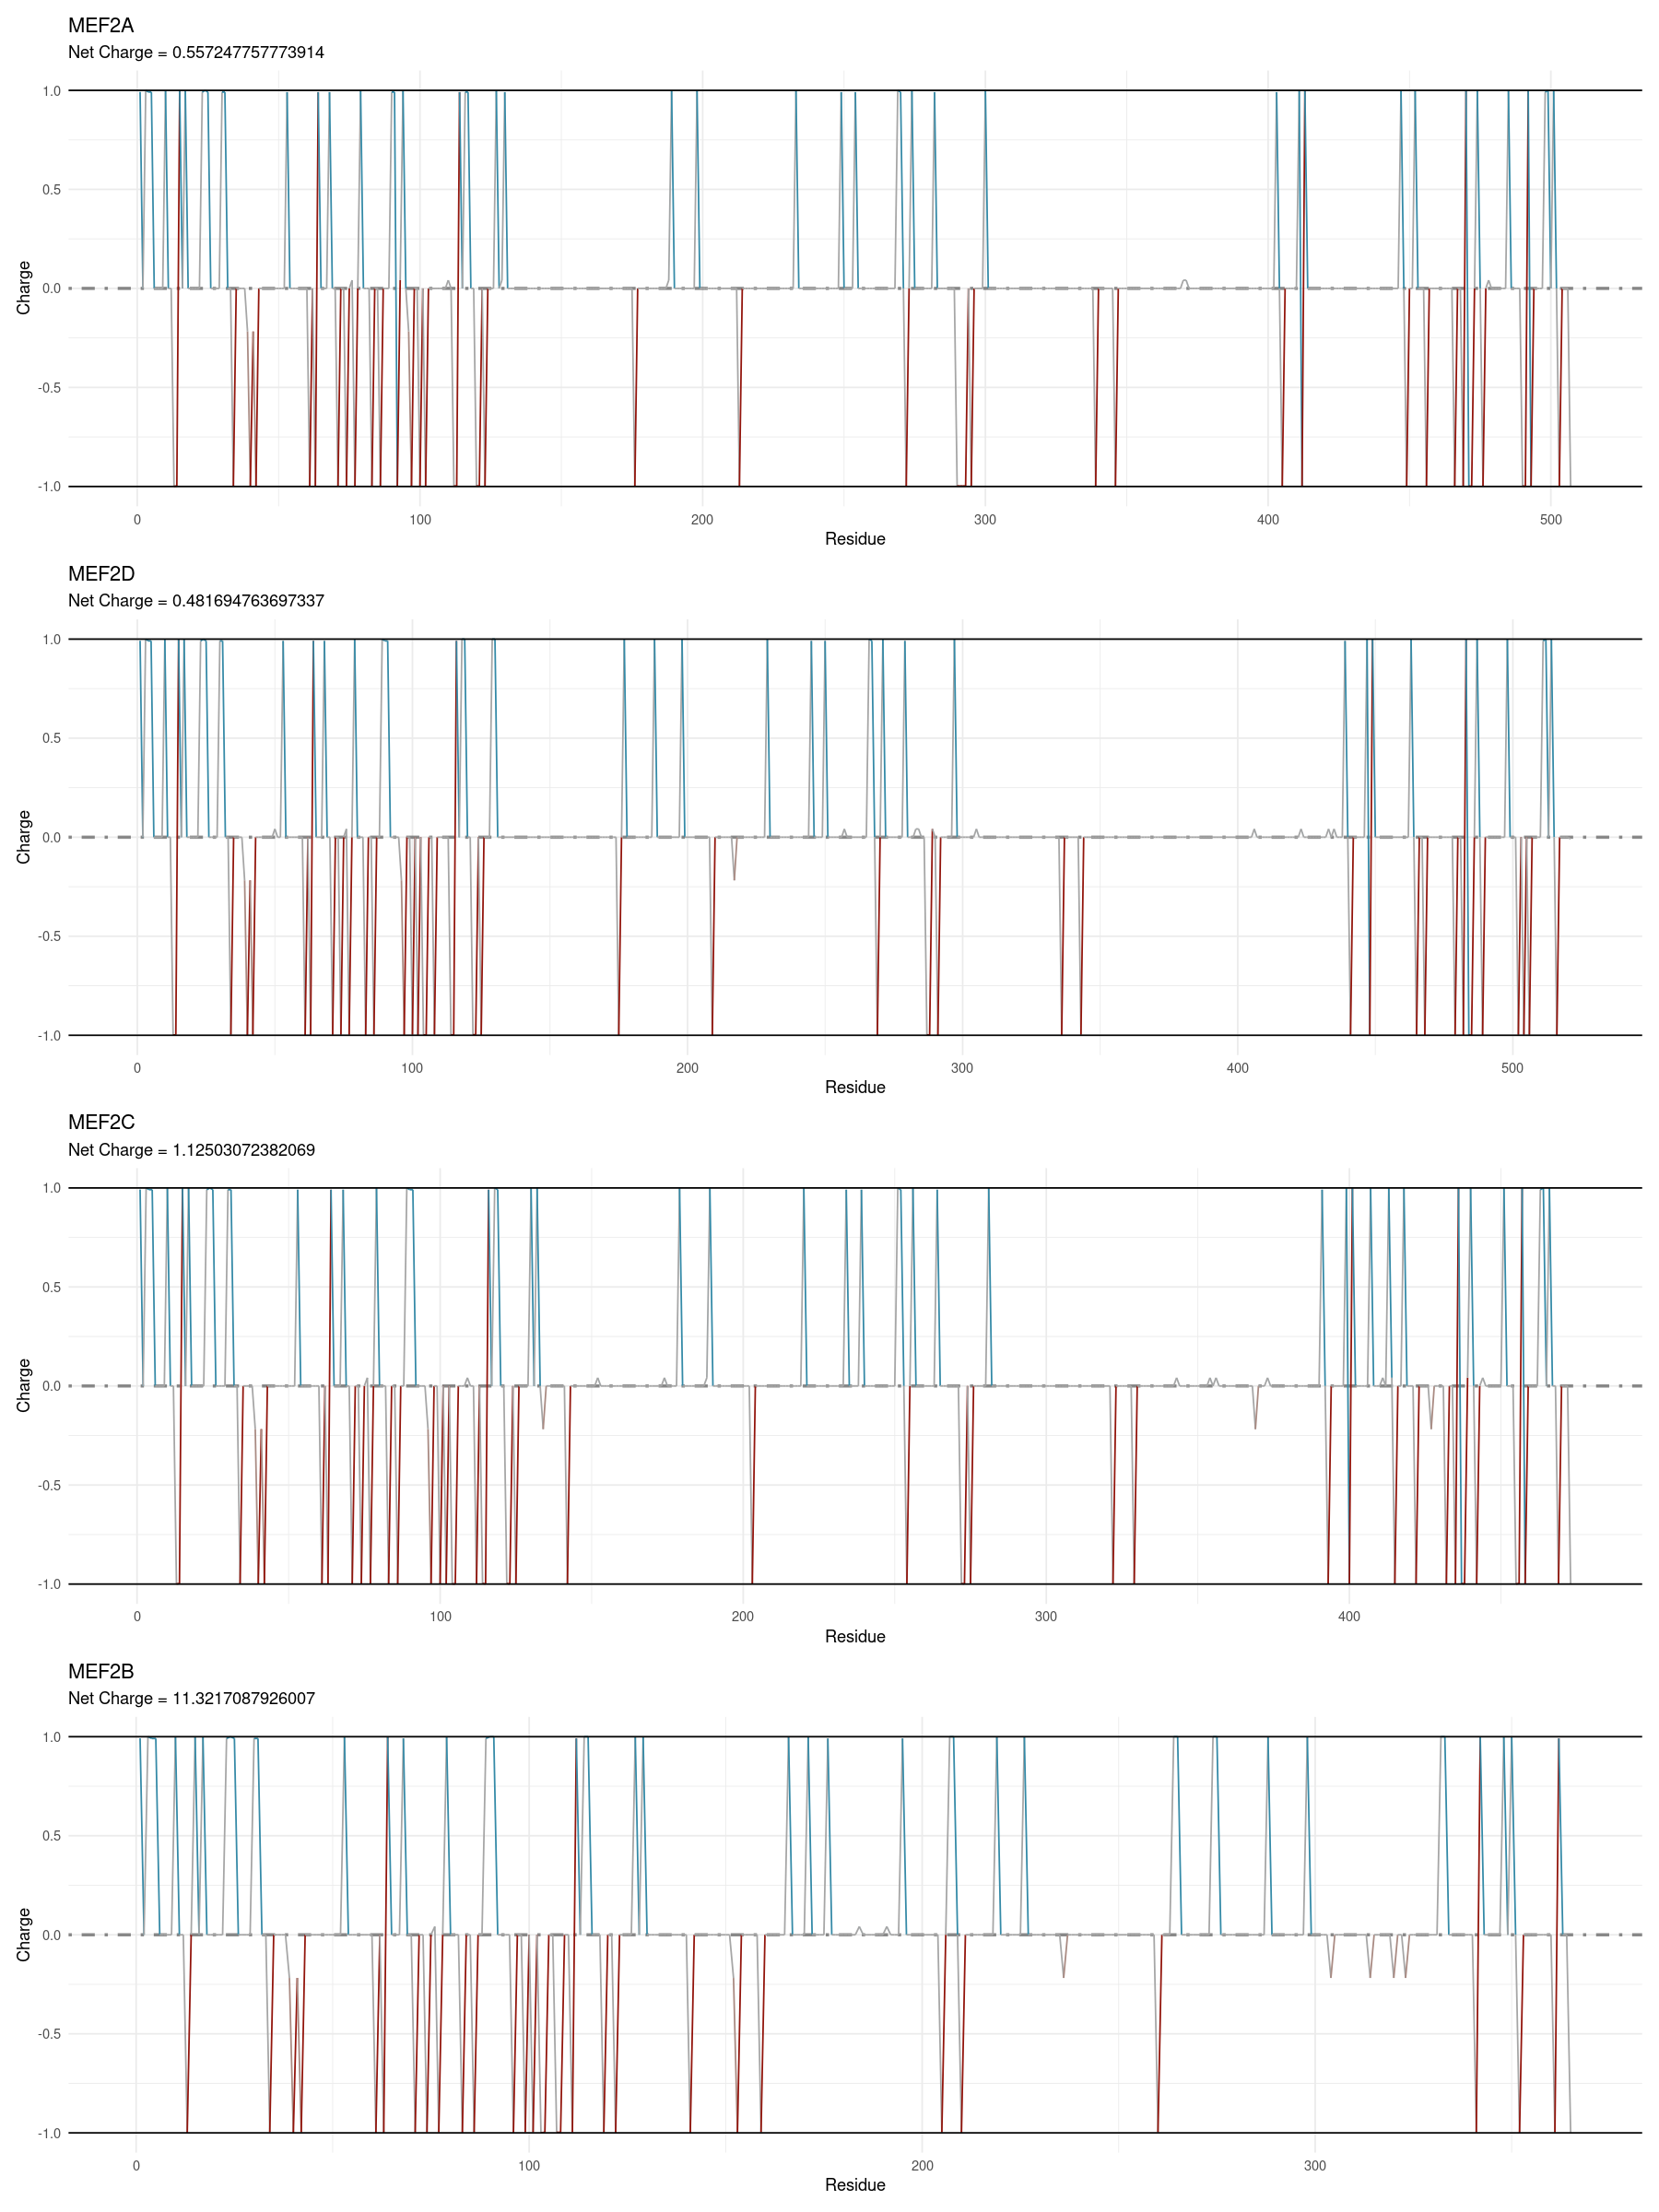

In [9]:
chgl_a <- chargeCalculationGlobal(mef2a, plotResults = TRUE) + ggtitle('MEF2A')
chgl_b <- chargeCalculationGlobal(mef2b, plotResults = TRUE) + ggtitle('MEF2B')
chgl_c <- chargeCalculationGlobal(mef2c, plotResults = TRUE) + ggtitle('MEF2C')
chgl_d <- chargeCalculationGlobal(mef2d, plotResults = TRUE) + ggtitle('MEF2D')

chgl_a / chgl_d / chgl_c / chgl_b

It is known that MEF2 proteins share highly conserved MADS-box and MEF2 domains. It is clearly seen on the plots above. However, the rest of the residues vary in the pattern. It is clear that if we describe hydrophobicity and charge of the whole protein the diffrences in the proteins will influence these descriptors.

### 1e) Choice of descriptors for statistical analysis

To summarise, we visually inspected four sequences parameters and have preferences of descriptors that link to the synapse activity regulation, these are:

- Glutamine frequency
- Charged amino acids frequencies
- Hydropathy (averaged)
- Net charge (averaged)

# 2. Analysis of MEF2 genes from other species.

### 2a) Phylogenetic tree of the chosen proteins

use default substitution matrix


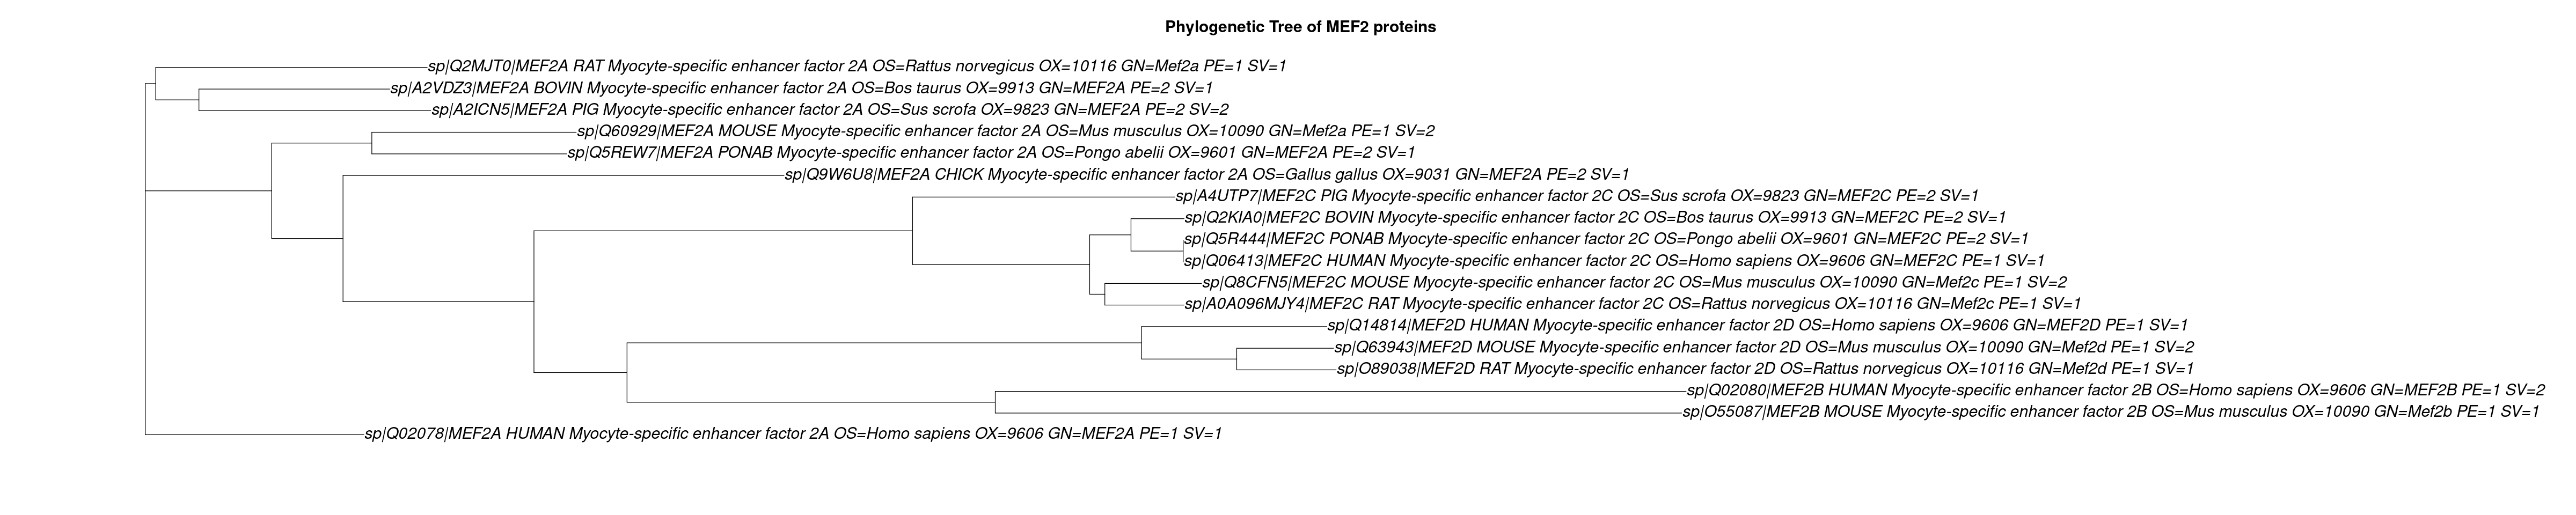

In [24]:
options(repr.plot.width=40, repr.plot.height=8)

all <- readAAStringSet('all_MEF2.fasta')

mef2al <- msa(all, 'ClustalW')
mef2al2 <- msaConvert(mef2al, type="seqinr::alignment")

distance <- dist.alignment(mef2al2, "identity")

mef2Tree <- nj(distance)
plot(mef2Tree, main="Phylogenetic Tree of MEF2 proteins", cex=1.5, cex.main = 1.5)

### 2b) Calculation of descriptors

Now we can calculate discussed descriptors for each protein and organise everything into a dataframe.

The 'synapse' column means participating in synapse regulation (1) or not (0).
The mean sacled hydropathy is calculated using Kyte-Doolittle scale and then rescaled in a range from 0 to 1.

In [11]:
fam <- readFASTA('all_MEF2.fasta')

species <- c('rat', 'pig', 'bovin', 'pig', 'mouse', 'rat', 'human', 'human', 'human', 'human',
             'bovin', 'rat', 'ponab', 'ponab', 'mouse', 'mouse', 'mouse', 'chicken')

synapse <- c(0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1)

df_species <- data.frame(species, synapse)

len <- rep(0, length(fam))
charge <- rep(0, length(fam))
hydropathy <- rep(0, length(fam))
polarAA <- rep(0, length(fam))
non_polarAA <- rep(0, length(fam))
q_plAA <- rep(0, length(fam))
q_mAA <- rep(0, length(fam))
gln <- rep(0, length(fam))

for (i in 1:length(fam)){
    
    len[i] <- nchar(fam[[i]])
    charge[i] <- netCharge(fam[[i]], averaged = TRUE)
    hydropathy[i] <- meanScaledHydropathy(fam[[i]])
    polarAA[i] <- sum((extractAAC(fam[[i]]))[polar])
    non_polarAA[i] <- sum((extractAAC(fam[[i]]))[non_polar])
    q_plAA[i] <- sum((extractAAC(fam[[i]]))[charge_pl])
    q_mAA[i] <- sum((extractAAC(fam[[i]]))[charge_m])
    gln[i] <- sum((extractAAC(fam[[i]]))['Q'])
    
}

df_species$length <- len
df_species$charge <- charge
df_species$hydropathy <- hydropathy
df_species$polarAA <- polarAA
df_species$non_polarAA <- non_polarAA
df_species$q_plAA <- q_plAA
df_species$q_mAA <- q_mAA
df_species$gln <- gln
df_species

species,synapse,length,charge,hydropathy,polarAA,non_polarAA,q_plAA,q_mAA,gln
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rat,0,473,0.0023785005,0.4297505,0.3361522,0.4460888,0.1247357,0.09302326,0.03594080
pig,1,507,-0.0047955989,0.4297475,0.3392505,0.4714004,0.1005917,0.08875740,0.06311637
bovin,1,492,0.0112690441,0.4342724,0.3373984,0.4756098,0.1077236,0.07926829,0.05691057
pig,0,463,0.0157831590,0.4244924,0.3455724,0.4406048,0.1295896,0.08423326,0.03455724
mouse,0,349,0.0288034230,0.4477994,0.2148997,0.5558739,0.1375358,0.09169054,0.02578797
rat,1,507,0.0087532503,0.4362525,0.2998028,0.5088757,0.1104536,0.08086785,0.06903353
human,1,507,0.0010991080,0.4256469,0.3471400,0.4615385,0.1045365,0.08678501,0.06903353
human,0,365,0.0310183803,0.4360493,0.2164384,0.5753425,0.1260274,0.08219178,0.03287671
human,0,473,0.0023785005,0.4291163,0.3361522,0.4460888,0.1247357,0.09302326,0.03594080


### 2c) Correlation between chosen descriptors and synapse regulation function

Now we can fisrtly see whether there is some correlation between chosen descriptors and 'synapse' column. In order to do this, we use Spearmen correlation, because 'synapse' is a categorical variable.

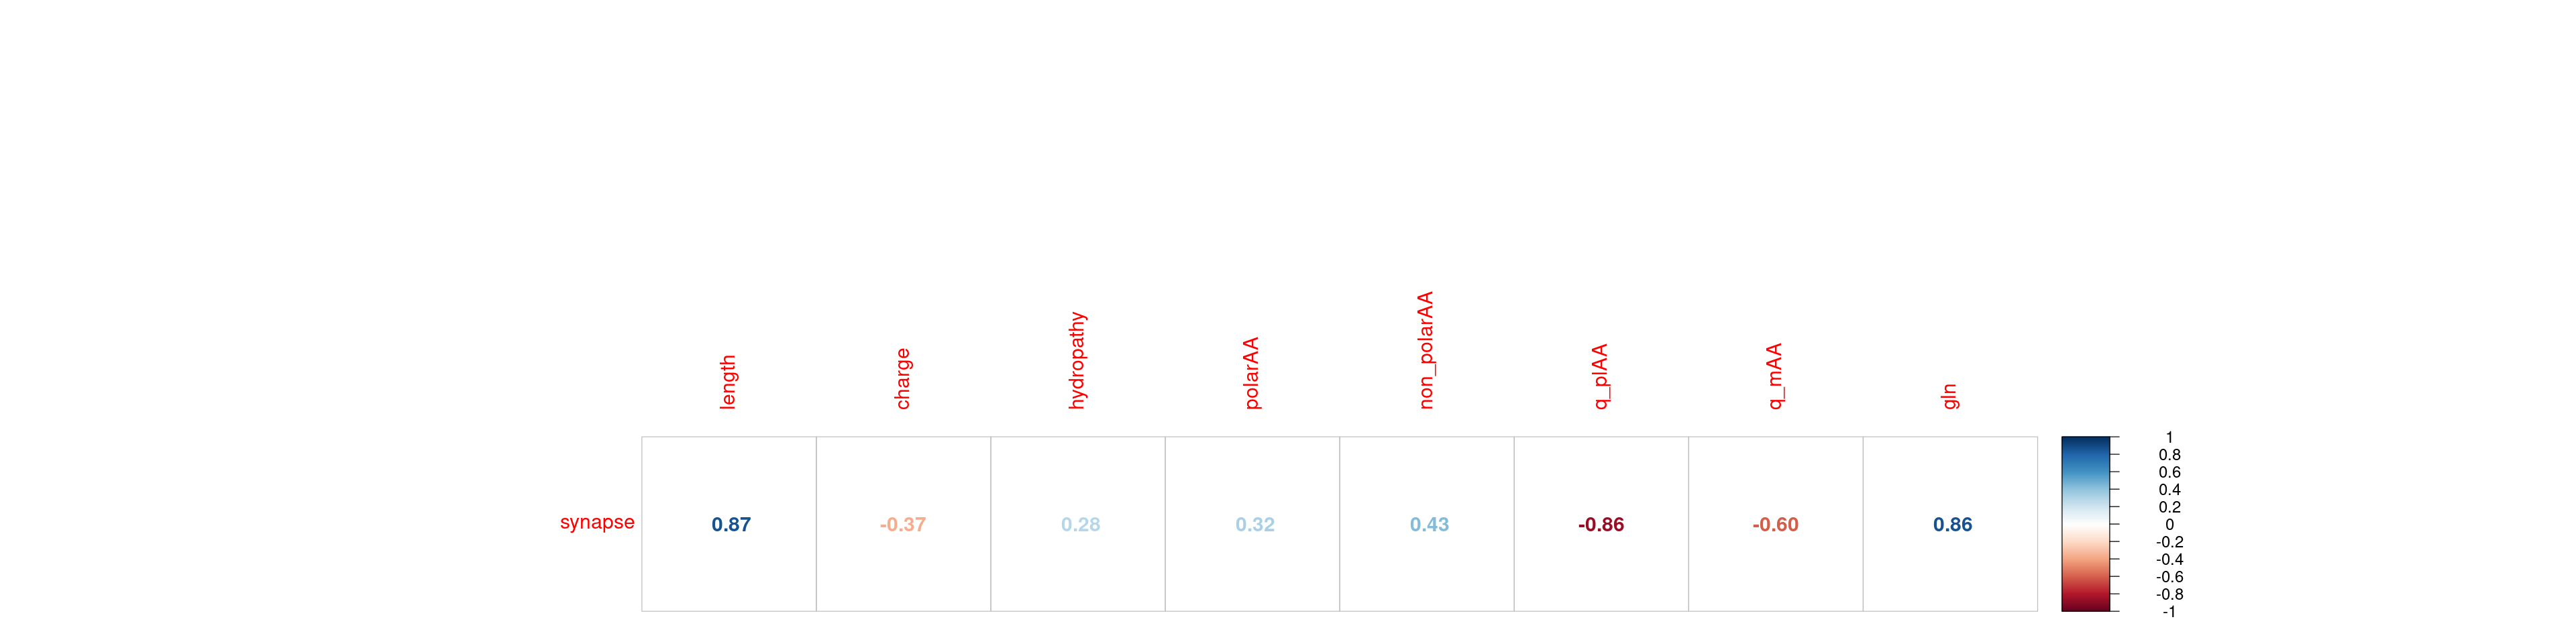

In [12]:
data <- subset(df_species, select = -species)


corrplot(cor(x = data[1], y = data[2:9], method = "spearman"),
  method = "number",
  type = "upper", tl.cex=1.5, cl.cex=1.2, number.cex = 1.5
)

options(repr.plot.width=16, repr.plot.height=6)

The first visual analysis of just four human MEF2 genes was quiet accurate, since we see high correlation (let us make a threshold of 0.5 without taking the sign into account) coefficients for such descriptors as length of the sequence, frequency of charged amino acids and the frequency of glutamine).


### 2d) T-test

Now it is interesting to perform t-test and see wheteher on average the difference between two groups of proteins (involved in synapse regulation and not) is statistically significant.

In order to achieve this we perform two-sided T-test.

Null hypothesis: means of the chosen descriptor are the same in two groups of proteins

Alternative hypothesis: means are not equal

CI: 95%.

#### Length of the sequence

In [13]:
length_ttest <- t.test(length ~ synapse, data = data)
length_ttest


	Welch Two Sample t-test

data:  length by synapse
t = -3.4716, df = 7.3699, p-value = 0.009574
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -108.0319  -21.0181
sample estimates:
mean in group 0 mean in group 1 
        438.875         503.400 


#### Positively charged amino acids

In [14]:
qpl_ttest <- t.test(q_plAA ~ synapse, data = data)
qpl_ttest


	Welch Two Sample t-test

data:  q_plAA by synapse
t = 11.163, df = 14.212, p-value = 2.018e-08
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.01817442 0.02680421
sample estimates:
mean in group 0 mean in group 1 
      0.1273521       0.1048628 


#### Nagatively charged amino acids

In [15]:
qm_ttest <- t.test(q_mAA ~ synapse, data = data)
qm_ttest


	Welch Two Sample t-test

data:  q_mAA by synapse
t = 2.7463, df = 13.508, p-value = 0.01618
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 0.00132706 0.01094121
sample estimates:
mean in group 0 mean in group 1 
     0.09093975      0.08480562 


#### Glutamine

In [16]:
gln_ttest <- t.test(gln ~ synapse, data = data)
gln_ttest


	Welch Two Sample t-test

data:  gln by synapse
t = -11.295, df = 13.035, p-value = 4.188e-08
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.03668584 -0.02490844
sample estimates:
mean in group 0 mean in group 1 
     0.03386536      0.06466250 


Seeing all the p-values for all the tests, we can conclude that at $\alpha = 0.05$ significance we can reject the Null hypothesis.

This means that in the data observed we see a difference in average length of the sequence, positevely/negatively charged amino acids' frequencies and glutamine frequency between non-participating and participating in synapse regulation proteins within MEF2 family.


## 3. Conclusion

The numerical results can be summarised as:

In [17]:
cat('The length of involved proteins is on average ',
    round(length_ttest$estimate[2] - length_ttest$estimate[1], 0),
   'residues longer than in non-involved (p-value =', round(length_ttest$p.value,3),', 95% CI).')

The length of involved proteins is on average  65 residues longer than in non-involved (p-value = 0.01 , 95% CI).

In [18]:
cat('The frequency of positevely charged amino acids in involved proteins is on average ',
    round(qpl_ttest$estimate[1] - qpl_ttest$estimate[2], 2),
   'lower than in non-involved (p-value =', round(qpl_ttest$p.value,10),', 95% CI).')

The frequency of positevely charged amino acids in involved proteins is on average  0.02 lower than in non-involved (p-value = 2.02e-08 , 95% CI).

In [19]:
cat('The frequency of negatively charged amino acids in involved proteins is on average ',
    round(qm_ttest$estimate[1] - qm_ttest$estimate[2], 2),
   'lower than in non-involved (p-value =', round(qm_ttest$p.value,2),', 95% CI).')

The frequency of negatively charged amino acids in involved proteins is on average  0.01 lower than in non-involved (p-value = 0.02 , 95% CI).

In [20]:
cat('The glutamine frequency in involved proteins is on average ',
    round(gln_ttest$estimate[2] - gln_ttest$estimate[1], 2),
   'bigger than in non-involved (p-value =', round(gln_ttest$p.value,10),', 95% CI).')

The glutamine frequency in involved proteins is on average  0.03 bigger than in non-involved (p-value = 4.19e-08 , 95% CI).